---
**Project**: Submarine Route Constraints  
**Author**: Alejandra L. Cameselle  
**Date**: July 2025  
**Notebook**: 05 – Generate Buffer Zones Around Point Constraints

### Description  
This notebook generates 500-meter buffer zones around point-based constraint layers, in order to reflect their spatial influence on submarine cable routing.  
Such features (e.g., wrecks or mud volcanoes) typically pose localized but critical risks, and require clearance distances to be properly accounted for in exclusion scoring.

**Note**:  
The buffer distance of **500 meters** has been uniformly applied here as a practical assumption for this project example.  
However, in real-world submarine cable planning, **each type of hazard or structure must be individually assessed** and the appropriate exclusion distance defined in consultation with engineers, regulators, and project-specific constraints.

### Inputs  
- `wrecks_clipped.gpkg`: Shipwreck locations  
- `pockmarks_clipped.gpkg`: Depressions from past fluid activity  
- `mud_mounts_clipped.gpkg`: Unstable sediment mounds  

### Processing  
- Load each point-based constraint layer  
- Generate 300 m buffer polygons  
- Clean geometries and ensure consistent CRS  
- Export as new layers for scoring integration

### Outputs  
- `wrecks_buffered_500m.gpkg`  
- `pockmarks_buffered_500m.gpkg`  
- `mud_mounts_buffered_500m.gpkg`  

### Assumptions  
- All input layers are in EPSG:25831 (meters)  
- Buffers are circular and isotropic  
- Buffer distance of 500 m is used for illustrative purposes  
- No weighting is applied here: only geometry generation  

### Dependencies  
- geopandas, shapely, os, matplotlib  
---

In [7]:
# Load required libraries
import geopandas as gpd
from shapely.geometry import Point
import os
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.patches import Patch
import rasterio
from rasterio.plot import show

In [8]:
# Load point-based constraint layers
wrecks = gpd.read_file("../processed_data/constraints/wrecks_clipped.gpkg")
pockmarks = gpd.read_file("../processed_data/constraints/pockmarks_clipped.gpkg")
mud_mounts = gpd.read_file("../processed_data/constraints/mud_mounts_clipped.gpkg")

print(f"Wrecks: {len(wrecks)} features")
print(f"Pockmarks: {len(pockmarks)} features")
print(f"Mud mounts: {len(mud_mounts)} features")

Wrecks: 10 features
Pockmarks: 156 features
Mud mounts: 6 features


In [9]:
# Generate 500-meter buffers around each point feature
wrecks_buffered = wrecks.copy()
wrecks_buffered["geometry"] = wrecks_buffered.geometry.buffer(500)

pockmarks_buffered = pockmarks.copy()
pockmarks_buffered["geometry"] = pockmarks_buffered.geometry.buffer(500)

mud_mounts_buffered = mud_mounts.copy()
mud_mounts_buffered["geometry"] = mud_mounts_buffered.geometry.buffer(500)

print("Buffers generated with 500 m radius for all point-based constraints.")

Buffers generated with 500 m radius for all point-based constraints.


In [10]:
# Clip buffered layers to AOI
aoi = gpd.read_file("../inputs/aoi.gpkg")

wrecks_buffered = gpd.overlay(wrecks_buffered, aoi, how="intersection")
pockmarks_buffered = gpd.overlay(pockmarks_buffered, aoi, how="intersection")
mud_mounts_buffered = gpd.overlay(mud_mounts_buffered, aoi, how="intersection")

print("Buffered layers clipped to AOI.")

Buffered layers clipped to AOI.


In [11]:
# Export clipped and buffered layers to disk
output_dir = "../processed_data"
os.makedirs(output_dir, exist_ok=True)

wrecks_buffered.to_file(f"{output_dir}/05_wrecks_buffered_500m.gpkg", driver="GPKG")
pockmarks_buffered.to_file(f"{output_dir}/05_pockmarks_buffered_500m.gpkg", driver="GPKG")
mud_mounts_buffered.to_file(f"{output_dir}/05_mud_mounts_buffered_500m.gpkg", driver="GPKG")

print("Clipped buffer layers exported to:")
print(f" - {output_dir}/wrecks_buffered_500m.gpkg")
print(f" - {output_dir}/pockmarks_buffered_500m.gpkg")
print(f" - {output_dir}/mud_mounts_buffered_500m.gpkg")

Clipped buffer layers exported to:
 - ../processed_data/wrecks_buffered_500m.gpkg
 - ../processed_data/pockmarks_buffered_500m.gpkg
 - ../processed_data/mud_mounts_buffered_500m.gpkg


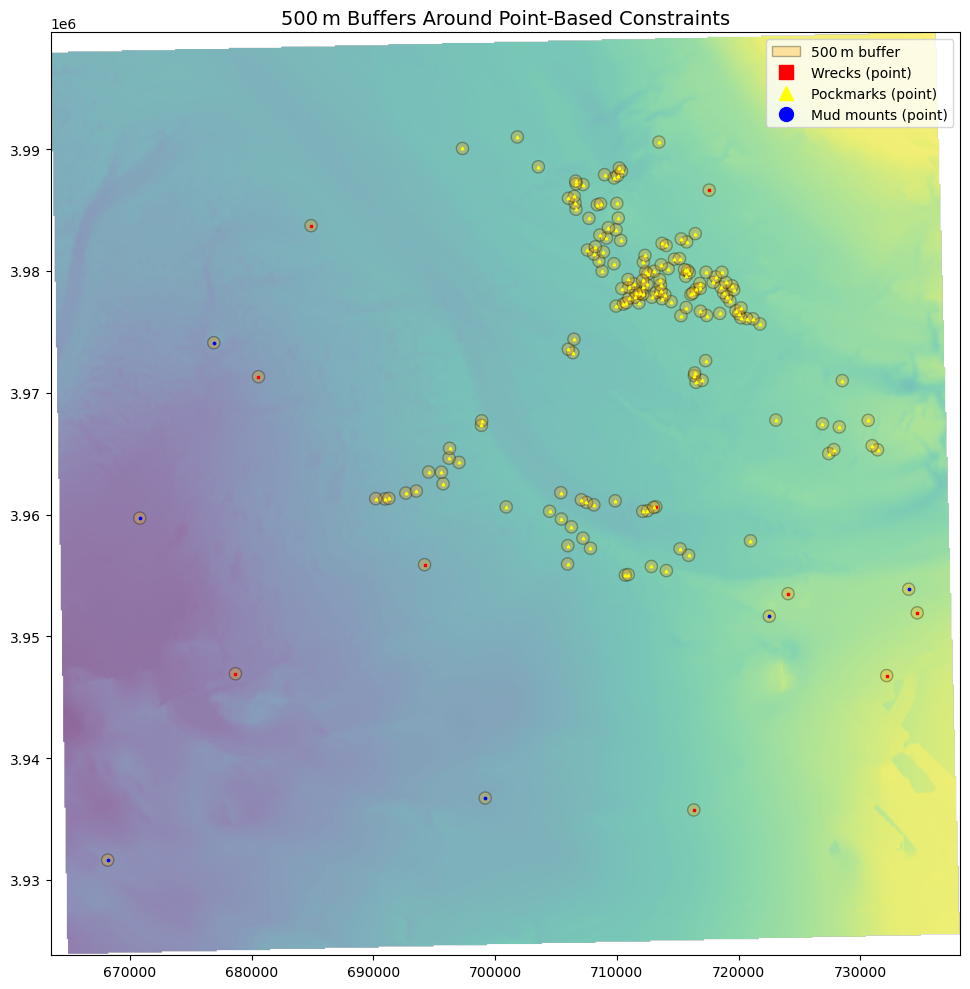

Map saved to: ../outputs/plots/05_point_buffer_zones.png


In [12]:
# Visualize buffered layers on top of the bathymetry raster and save figure

# Load original point layers
wrecks_points = gpd.read_file("../processed_data/constraints/wrecks_clipped.gpkg")
pockmarks_points = gpd.read_file("../processed_data/constraints/pockmarks_clipped.gpkg")
mud_mounts_points = gpd.read_file("../processed_data/constraints/mud_mounts_clipped.gpkg")

# Plotting
fig, ax = plt.subplots(figsize=(11, 10))

# Plot raster background
with rasterio.open("../inputs/bathymetry_clipped.tif") as src:
    show(src, ax=ax, cmap="viridis", alpha=0.6)

# Plot buffer polygons (orange fill, semi-transparent)
wrecks_buffered.plot(ax=ax, facecolor="orange", edgecolor="black", alpha=0.3)
pockmarks_buffered.plot(ax=ax, facecolor="orange", edgecolor="black", alpha=0.3)
mud_mounts_buffered.plot(ax=ax, facecolor="orange", edgecolor="black", alpha=0.3)

# Plot original point features with distinct markers
wrecks_points.plot(ax=ax, color="red", marker="s", markersize=3, label="Wrecks (point)")
pockmarks_points.plot(ax=ax, color="yellow", marker="^", markersize=3, label="Pockmarks (point)")
mud_mounts_points.plot(ax=ax, color="blue", marker="o", markersize=3, label="Mud mounts (point)")

# Custom legend
legend_elements = [
    Patch(facecolor="orange", edgecolor="black", alpha=0.3, label="500 m buffer"),
    mlines.Line2D([], [], color="red", marker="s", linestyle='None', markersize=10, label="Wrecks (point)"),
    mlines.Line2D([], [], color="yellow", marker="^", linestyle='None', markersize=10, label="Pockmarks (point)"),
    mlines.Line2D([], [], color="blue", marker="o", linestyle='None', markersize=10, label="Mud mounts (point)")
]

ax.legend(handles=legend_elements, loc="upper right")
ax.set_title("500 m Buffers Around Point-Based Constraints", fontsize=14)
plt.tight_layout()

# Save figure
plot_path = "../outputs/plots/05_point_buffer_zones.png"
os.makedirs(os.path.dirname(plot_path), exist_ok=True)
plt.savefig(plot_path, dpi=300)
plt.show()

print(f"Map saved to: {plot_path}")